In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
from itertools import compress

<h3>Retrieve <code>od_dfs</code> (same as used in raw_data_vis.ipynb)</h3>

In [2]:
od_files=["data_2016.csv","data_2017.csv","data_2018.csv","data_2019.csv"]
years = [name.split(".csv")[0].split("_")[1] for name in od_files]

In [3]:
od_dfs = []
for yr in years:
    df = gpd.read_file("data/saved_odDFs/Dataframe_OD_"+str(yr)+".shp")
    df = df.set_index('county')
    od_dfs.append(df)

# Generate random OD events based on historical data

In [4]:
od_history = od_dfs[0][['geometry']].copy()
maxODs = []
minODs = []
for county in od_history.index:
    allODs = []
    for i in range(len(od_dfs)):
        allODs.append(int(od_dfs[i]['od_count'][county]))
    maxODs.append(max(allODs))
    minODs.append(min(allODs))

od_history['maxODcount'] = maxODs
od_history['minODcount'] = minODs

We now have max/min OD counts for each county based on past data. We can generate a random number of simulated OD calls that's within this range to simulate fluctuation.

Furthermore, since this data is for the entire year, we can add randomness to the days on which these calls are generated. <br>
A maximum duplicate value can be set, to ensure we don't run into a situation where all the calls happen on the same day.

for county in counties:
    N = random.randint(1,maxN) # maxN is max number of days in a year when ODs can happen max(total ODs,days in yr)
    days = random.sample(range(0,365),N) # where N is number of days
    odN = random.randint(minOD,maxOD) # odN is the number of annual cases we will have
    leftover = odN # cases left to simulate
    for day in days:
        if leftover> 0 :
            K = random.randint(0,maxK /* odN) # K is num of cases/day, maxK is max cases a day (% of annual cases)
            leftover = odN - K
            ... something to randomly locate these cases on a map

In [40]:
def generateRandomPts(geometry,n):
    generated = 0
    ptslist = []
    minX,minY,maxX,maxY = geometry.bounds
    while generated < n:
        x = np.random.uniform(minX,maxX,n)
        y = np.random.uniform(minY,maxY,n)
        
        pts = [Point(xi,yi) for xi,yi in zip(x,y)]
        
        contained = geometry.contains(pts)
        generated += contained.sum()
        ptslist+=list(compress(pts,contained))
    return GeoDataFrame(ptslist[:n]).rename(columns={0:'odpts'})

In [84]:
daysYr = 365
printOutput = False

for countyName,countygeo,maxOD,minOD in zip(od_history.index,od_history['geometry'],od_history['maxODcount'],od_history['maxODcount']):
    maxDays = min(maxOD,daysYr) # max number of days with OD is either max possible OD count or num of days in a year
    numDays = random.randint(0,maxDays) # number of days that will have OD cases, minimum 1 day
    days = random.sample(range(0,daysYr),numDays) # the actual days in which ODs will occur, sample size is the number of days we want ODs
    
    odYr = random.randint(minOD,maxOD) # count of OD cases that will occur annually, within historical margins
    odRemaining = odYr # as we go through the year, variable to store leftover cases
    
    # We need to set a limit for max OD in a day, to prevent annual OD numbers from happening in a single day
    # However, a single percentage will limit smaller counties to 1 case/day, whereas large counties will have too many/day
    # Thus, we have a piecewise scale. Let N = number of cases a year, then
    # N >= 100, max 1% of annual cases a day (roughly 1-20 cases/day on IN data)
    # N >= 10, max 5% of annual cases a day (roughly 1-5 cases/day on IN data)
    # N >= 0, max 30% of annual cases a day (roughly 1-3 cases/day on IN data)
    maxODday = 0.01 if odYr>=100 else (0.05 if odYr >=10 else 0.3)
    if printOutput: print(str(countyName)+" has: ")
    for day in days: # go through each day we have OD
        if odRemaining > 0: # as long as we still have cases to left simulate for the year
            odDay = random.randint(0,np.ceil(maxODday*odYr)) # number of cases on this day
            odRemaining = odYr - odDay
            if odDay == 0:
                continue
            else:
                odpts = generateRandomPts(countygeo,odDay)
                break
            if printOutput: print("Day "+str(day)+", "+str(odDay)+" case(s). | ",end='')
            
        else:
            continue
    if printOutput: print("\n")
    break

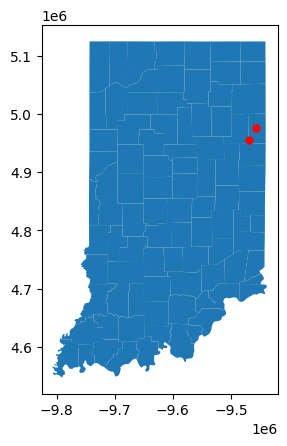

In [85]:
ax = od_history.plot()
plt.plot([row.x for row in odpts['odpts']],[row.y for row in odpts['odpts']],'o',markersize=5,color='red')

In [35]:
odpts

,odpts
0,POINT (-9467272.63247533 5000047.031360216)
1,POINT (-9445868.057026263 4956082.007941794)


In [262]:
geo = od_history['geometry']['Spencer']
x1,y1,x2,y2 = geo.bounds
n=100
x = np.random.uniform(x1,x2,n)
y = np.random.uniform(y1,y2,n)

In [270]:
pts = ([Point(xi,yi) for xi,yi in zip(x,y)])

In [275]:
list(compress(pts,geo.contains(pts)))

[<POINT (-9691247.256 4557455.828)>,
 <POINT (-9669999.499 4594157.362)>,
 <POINT (-9698160.534 4569427.212)>,
 <POINT (-9687040.395 4593512.354)>,
 <POINT (-9676049.249 4573084.244)>,
 <POINT (-9702666.879 4558663.753)>,
 <POINT (-9686433.03 4584823.051)>,
 <POINT (-9674065.079 4593541.88)>,
 <POINT (-9686108.618 4603803.418)>,
 <POINT (-9663551.578 4582149.027)>,
 <POINT (-9693819.619 4579340.885)>,
 <POINT (-9697801.353 4585004.287)>,
 <POINT (-9670052.986 4585059.934)>,
 <POINT (-9681840.702 4598455.89)>,
 <POINT (-9692881.539 4565520.633)>,
 <POINT (-9687479.158 4567903.636)>,
 <POINT (-9703657.917 4571065.63)>,
 <POINT (-9664440.834 4607806.278)>,
 <POINT (-9693541.903 4551994.5)>,
 <POINT (-9666452.104 4584500.071)>,
 <POINT (-9677707.281 4571680.158)>,
 <POINT (-9675203.171 4579555.357)>,
 <POINT (-9700440.529 4577808.298)>,
 <POINT (-9680981.282 4577052.594)>,
 <POINT (-9666807.014 4602271.725)>,
 <POINT (-9712014.673 4563509.066)>,
 <POINT (-9674813.109 4572359.277)>,
 <POINT

In [278]:
GeoDataFrame(list(compress(pts,geo.contains(pts)))).rename(columns={0:'pointslol'})

,pointslol
0,POINT (-9691247.255896388 4557455.82831754)
1,POINT (-9669999.498721136 4594157.362248644)
2,POINT (-9698160.53421505 4569427.21189883)
3,POINT (-9687040.394756248 4593512.35402325)
4,POINT (-9676049.249373117 4573084.243525416)
5,POINT (-9702666.879432913 4558663.753341853)
6,POINT (-9686433.03020957 4584823.050858488)
7,POINT (-9674065.078824194 4593541.879735671)
8,POINT (-9686108.61792492 4603803.417969059)
9,POINT (-9663551.57847512 4582149.0274314005)


In [10]:
biglst = [1,2,3,4,5,6,7,8,9]
n = [266,66]

In [11]:
biglst+n

[1, 2, 3, 4, 5, 6, 7, 8, 9, 266, 66]

In [280]:
biglst[:n]

[1, 2, 3, 4]

In [178]:
od_history['geometry']['Marion'].bounds

(-9610002.470860107, 4812634.328610508, -9566505.270388562, 4855396.685822271)